In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
import glob

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Home'
ODDS = 'Odds_H'

# Carregando o dataset

In [3]:
data = pd.read_excel('../../base_basquete_2.xlsx')

In [4]:
def prepara_dataset(_df):

    # Apenas odds_Home abaixo de 5
    _df = _df[(_df['Odds_H'] >= 1.5) & (_df['Odds_H'] < 2.5)]
    
    # Limpando o df
    # _df = _df[(_df['Avg_CG_H'] != 0) & (_df['Avg_CG_A'] != 0)]

    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    # _df.dropna(subset=[TARGET], inplace=True)
    
    _df.reset_index(drop=True, inplace=True)
    
    return _df

In [5]:
df = data.copy()
df = df[df['Date'] < '2023-11-08']
df = prepara_dataset(df)

In [6]:
TRAIN_SIZE = 0.625

div = int(TRAIN_SIZE * len(df))
treino = df.iloc[:div, :]
val = df.iloc[div: , :]

print(f"Odd média: {treino[ODDS].mean():.2f}")
print(f"WR: {treino[TARGET].mean():.2f} (Odd justa: {1 / treino[TARGET].mean():.2f})")
print(f"\nEspaço amostral: {treino.shape[0]}")
print(f'Validação: {val.shape[0]}')

Odd média: 1.86
WR: 0.51 (Odd justa: 1.95)

Espaço amostral: 1535
Validação: 922


# Criação do modelo

In [21]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', ODDS]

features = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML', 'CV_Over', 'CV_HA', ODDS]

features = ['Over_Line', 'P(A)', 'CV_Over', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_Odds_A', 'Odds_Over', 'CV_HA', 'Odds_H']


In [22]:
def cria_setup(seed = 2023, features = features):
    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
            target = TARGET,
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = seed,
            remove_outliers = True,
            fix_imbalance = True,
            verbose = False
            )

In [23]:
cria_setup(seed = 2023, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [24]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5438,0.5716,0.5521,0.5612,0.5551,0.0864,0.0869,0.2080
ridge,Ridge Classifier,0.5412,0.0000,0.5648,0.5575,0.5591,0.0805,0.0810,0.1780
svm,SVM - Linear Kernel,0.4758,0.0000,0.3538,0.5420,0.3134,-0.0411,-0.0476,0.1800
lda,Linear Discriminant Analysis,0.5281,0.5565,0.5900,0.5409,0.5610,0.0522,0.0513,0.1760
nb,Naive Bayes,0.5385,0.5697,0.8900,0.5397,0.6606,0.0583,0.0680,0.1760
et,Extra Trees Classifier,0.5214,0.5232,0.4859,0.5355,0.5086,0.0446,0.0447,0.2980
rf,Random Forest Classifier,0.5214,0.5254,0.5164,0.5334,0.5234,0.0430,0.0431,0.2820
ada,Ada Boost Classifier,0.5216,0.5427,0.5446,0.5332,0.5378,0.0419,0.0419,0.2040
gbc,Gradient Boosting Classifier,0.5073,0.5084,0.5219,0.5208,0.5208,0.0138,0.0137,0.2180
knn,K Neighbors Classifier,0.5059,0.5251,0.4936,0.5181,0.5050,0.0123,0.0122,0.1880


In [25]:
model = create_model('lr', cross_validation=False, return_train_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.5872,0.5949,0.6041,0.5965,0.6003,0.1736,0.1737
Train,0.5632,0.5923,0.5878,0.5718,0.5797,0.1253,0.1254


In [53]:
ranges_dict['CV_ML']

[Interval(0.358, 0.404, closed='right'),
 Interval(0.205, 0.274, closed='right'),
 Interval(-0.001, 0.125, closed='right'),
 Interval(0.125, 0.205, closed='right'),
 Interval(0.274, 0.358, closed='right')]

In [54]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[(_df['CV_ML'] >= 0) & (_df['CV_Over'] < 0.404)]

        
    return _df

In [11]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
    _df['hbacu'].plot.line(figsize=(7,2))
    plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET]], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df)
    
    return _df


PL: -25.76 | ROI: -6.38% | Prec.: 0.57
Odd média: 1.64 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.07
404 entradas em 767 jogos (52.67%)


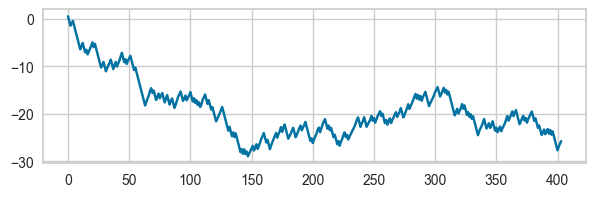

PL: -7.18 | ROI: -1.80% | Prec.: 0.60
Odd média: 1.65 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: -0.01
399 entradas em 768 jogos (51.95%)


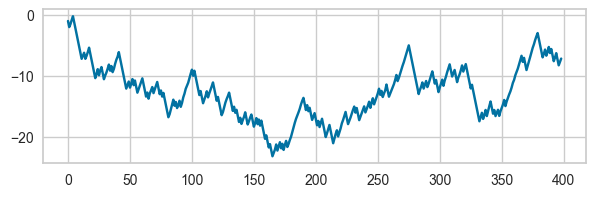

PL: -32.94 | ROI: -4.10% | Prec.: 0.58
Odd média: 1.65 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.05
803 entradas em 1535 jogos (52.31%)


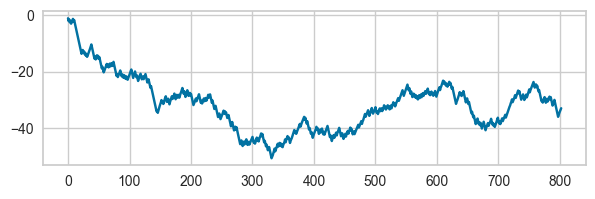

In [55]:
flt = 1
mdl = model

df_treino = info_modelo(mdl, real_treino, filtro = flt)
df_teste = info_modelo(mdl, real_teste, filtro = flt)
df_comp = info_modelo(mdl, treino, filtro = flt)

In [ ]:
df_val = info_modelo(mdl, val, filtro = flt)

In [ ]:
aux_comp = treina_modelo(mdl, real_teste)
aux_comp = filtra_resultados(aux_comp, filtro = flt)
plt.axvline(x=len(aux_comp), color='red', linestyle='--')
aux = info_modelo(mdl, pd.concat([real_teste, val]), filtro = flt)

# Simulação de apostas

In [12]:
temp = pd.read_csv('../../../data/Entire_Season.csv')
itens = glob.glob('../../../jogos_processados/*.csv')
itens = itens[:-1]

sim = pd.DataFrame()

for i in itens:
    aux = pd.read_csv(i)
    sim = pd.concat([sim, aux])
sim.reset_index(drop=True, inplace=True)

sim = sim.merge(temp[['Date', 'Home', 'Away', 'Home_Pts', 'Away_Pts']], on=['Date', 'Home', 'Away'], how='left')

sim = prepara_dataset(sim)

In [ ]:
df_sim = info_modelo(mdl, sim, filtro = flt)

# QCut automático

In [49]:
def find_pos_range(var, treino, teste, ratio = 0.03, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = df_val[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = df_val[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_top_range(var, treino, teste, n_ranges = 3, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5)

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:n_ranges]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = df_val[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = df_val[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_neg_range(var, treino, teste, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = val[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = val[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges

In [56]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()

Over_Line

---------------------  TREINO  ---------------------
PL: -27.06 | ROI: -8.30% | Prec.: 0.56
Odd média: 1.65 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.08
326 entradas em 767 jogos (42.50%)


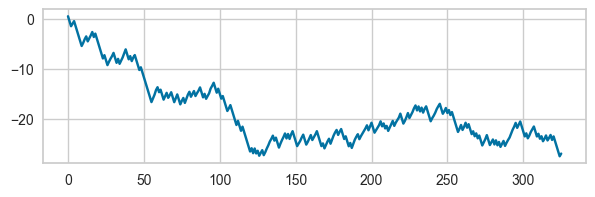

---------------------  TESTE  ---------------------
PL: 13.57 | ROI: 4.28% | Prec.: 0.63
Odd média: 1.65 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: 0.04
317 entradas em 768 jogos (41.28%)


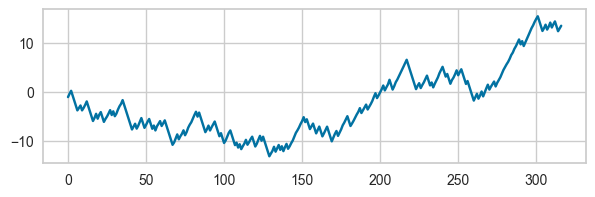




P(A)

---------------------  TREINO  ---------------------
PL: -28.89 | ROI: -9.66% | Prec.: 0.54
Odd média: 1.69 (0.59 WR)
Média Gain: 0.69 | Média Loss: -1.00
EM: -0.09
299 entradas em 767 jogos (38.98%)


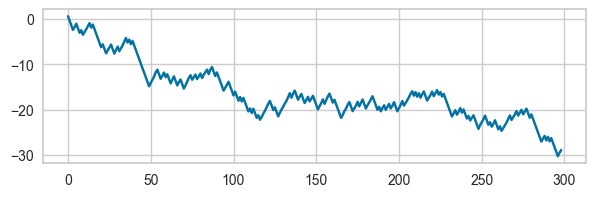

---------------------  TESTE  ---------------------
PL: 1.02 | ROI: 0.33% | Prec.: 0.60
Odd média: 1.69 (0.59 WR)
Média Gain: 0.68 | Média Loss: -1.00
EM: 0.01
307 entradas em 768 jogos (39.97%)


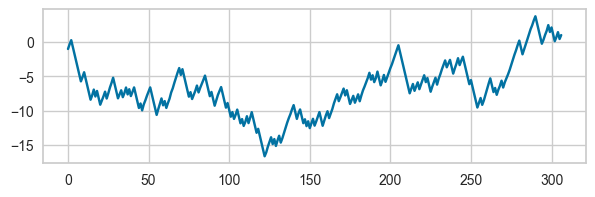




CV_Over

---------------------  TREINO  ---------------------
PL: 0.95 | ROI: 95.00% | Prec.: 1.00
Odd média: 1.95 (0.51 WR)
Média Gain: 0.95 | Média Loss: nan
EM: nan
1 entradas em 767 jogos (0.13%)


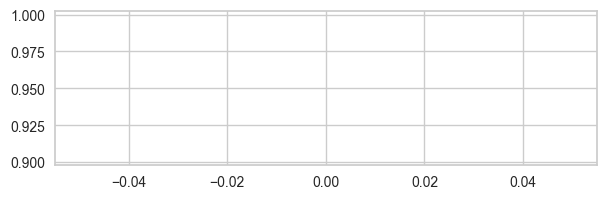

---------------------  TESTE  ---------------------
P(H)

---------------------  TREINO  ---------------------
PL: -28.89 | ROI: -9.66% | Prec.: 0.54
Odd média: 1.69 (0.59 WR)
Média Gain: 0.69 | Média Loss: -1.00
EM: -0.09
299 entradas em 767 jogos (38.98%)


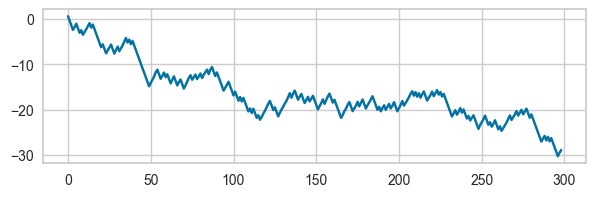

---------------------  TESTE  ---------------------
PL: -0.06 | ROI: -0.02% | Prec.: 0.59
Odd média: 1.69 (0.59 WR)
Média Gain: 0.68 | Média Loss: -1.00
EM: -0.01
305 entradas em 768 jogos (39.71%)


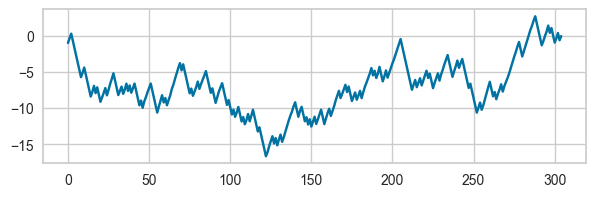




P_Diff

---------------------  TREINO  ---------------------
PL: -19.82 | ROI: -6.04% | Prec.: 0.57
Odd média: 1.66 (0.60 WR)
Média Gain: 0.66 | Média Loss: -1.00
EM: -0.06
328 entradas em 767 jogos (42.76%)


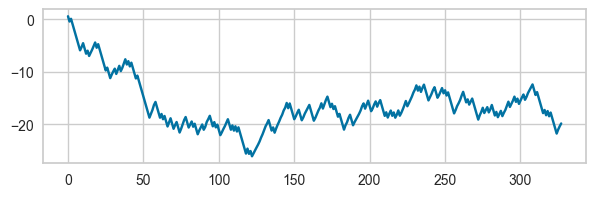

---------------------  TESTE  ---------------------
PL: -7.56 | ROI: -2.26% | Prec.: 0.59
Odd média: 1.67 (0.60 WR)
Média Gain: 0.66 | Média Loss: -1.00
EM: -0.02
335 entradas em 768 jogos (43.62%)


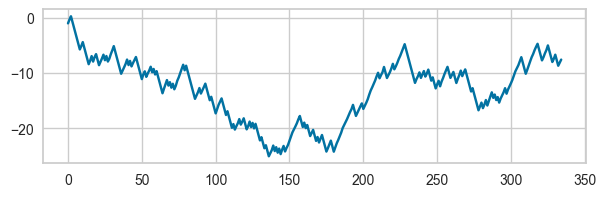




CV_ML

---------------------  TREINO  ---------------------
PL: -27.24 | ROI: -7.55% | Prec.: 0.56
Odd média: 1.66 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: -0.07
361 entradas em 767 jogos (47.07%)


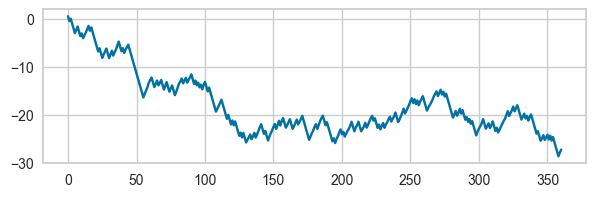

---------------------  TESTE  ---------------------
PL: -0.78 | ROI: -0.21% | Prec.: 0.60
Odd média: 1.66 (0.60 WR)
Média Gain: 0.66 | Média Loss: -1.00
EM: -0.01
365 entradas em 768 jogos (47.53%)


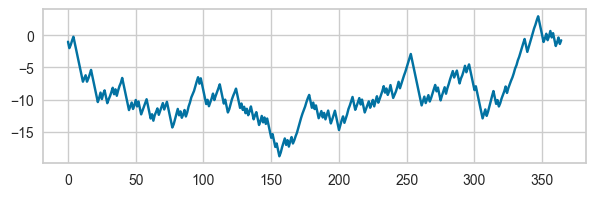




HA_Odds_H

---------------------  TREINO  ---------------------
PL: -1.69 | ROI: -4.45% | Prec.: 0.61
Odd média: 1.59 (0.63 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: -0.04
38 entradas em 767 jogos (4.95%)


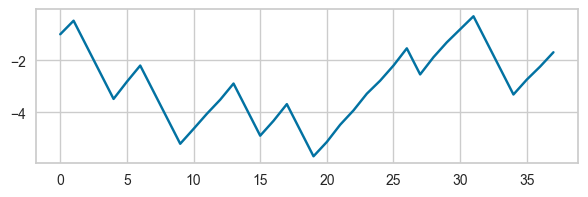

---------------------  TESTE  ---------------------
PL: 2.95 | ROI: 9.22% | Prec.: 0.69
Odd média: 1.59 (0.63 WR)
Média Gain: 0.59 | Média Loss: -1.00
EM: 0.10
32 entradas em 768 jogos (4.17%)


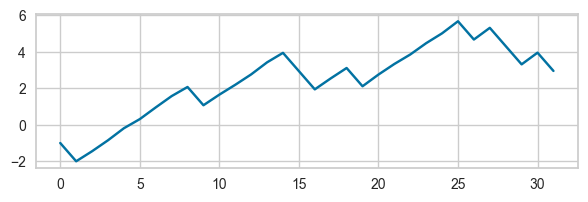




Odds_A

---------------------  TREINO  ---------------------
PL: -28.24 | ROI: -7.80% | Prec.: 0.56
Odd média: 1.66 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: -0.07
362 entradas em 767 jogos (47.20%)


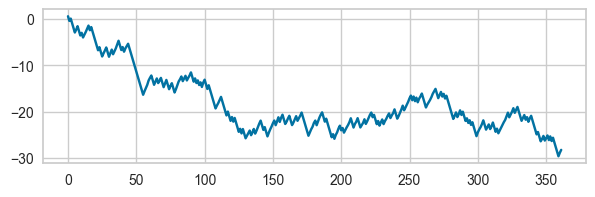

---------------------  TESTE  ---------------------
PL: -0.78 | ROI: -0.21% | Prec.: 0.60
Odd média: 1.66 (0.60 WR)
Média Gain: 0.66 | Média Loss: -1.00
EM: -0.01
365 entradas em 768 jogos (47.53%)


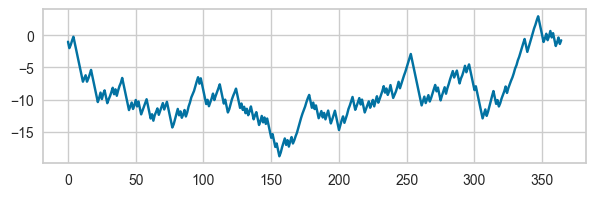




P(U)

---------------------  TREINO  ---------------------
PL: -2.81 | ROI: -25.55% | Prec.: 0.45
Odd média: 1.66 (0.60 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.26
11 entradas em 767 jogos (1.43%)


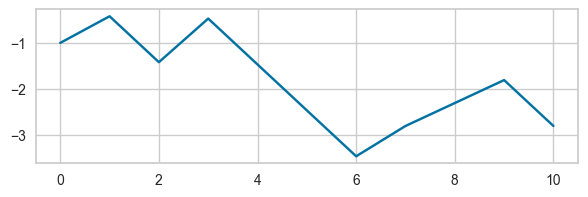

---------------------  TESTE  ---------------------
PL: 1.66 | ROI: 11.86% | Prec.: 0.64
Odd média: 1.70 (0.59 WR)
Média Gain: 0.74 | Média Loss: -1.00
EM: 0.11
14 entradas em 768 jogos (1.82%)


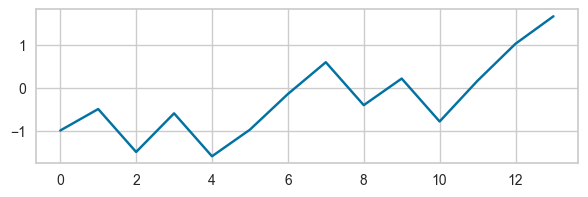




HA_Odds_A

---------------------  TREINO  ---------------------
PL: -19.69 | ROI: -5.59% | Prec.: 0.58
Odd média: 1.64 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.05
352 entradas em 767 jogos (45.89%)


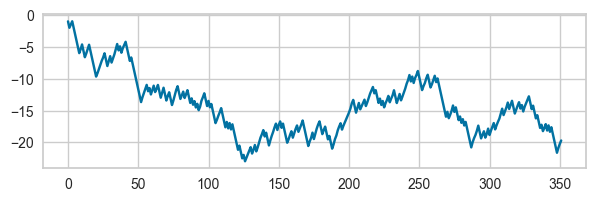

---------------------  TESTE  ---------------------
PL: 2.49 | ROI: 0.73% | Prec.: 0.61
Odd média: 1.65 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: 0.00
341 entradas em 768 jogos (44.40%)


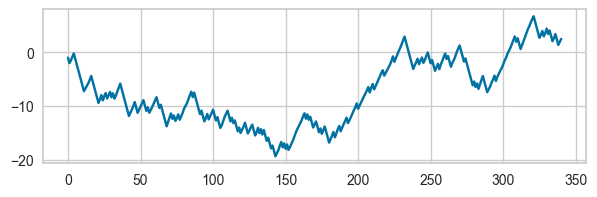




Odds_Over

---------------------  TREINO  ---------------------
PL: -25.76 | ROI: -6.38% | Prec.: 0.57
Odd média: 1.64 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.07
404 entradas em 767 jogos (52.67%)


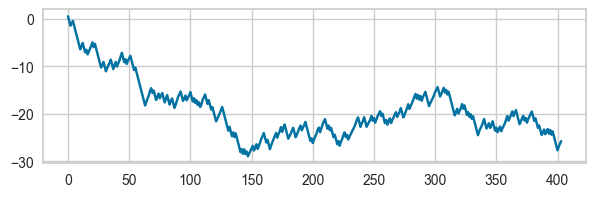

---------------------  TESTE  ---------------------
PL: -7.18 | ROI: -1.80% | Prec.: 0.60
Odd média: 1.65 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: -0.01
399 entradas em 768 jogos (51.95%)


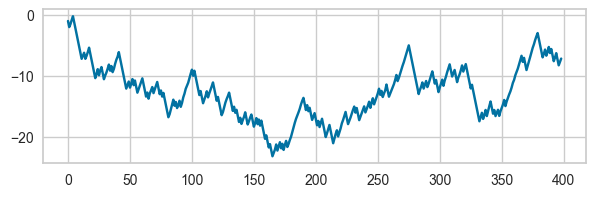




CV_HA

---------------------  TREINO  ---------------------
PL: -18.00 | ROI: -5.73% | Prec.: 0.57
Odd média: 1.65 (0.61 WR)
Média Gain: 0.64 | Média Loss: -1.00
EM: -0.06
314 entradas em 767 jogos (40.94%)


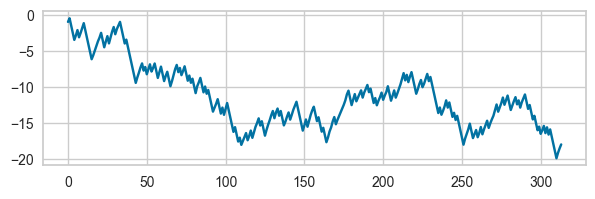

---------------------  TESTE  ---------------------
PL: -0.46 | ROI: -0.15% | Prec.: 0.61
Odd média: 1.65 (0.60 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: 0.01
309 entradas em 768 jogos (40.23%)


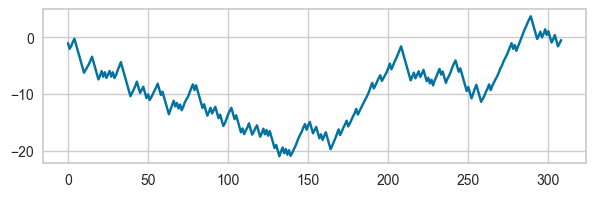




Odds_H

---------------------  TREINO  ---------------------
PL: -28.89 | ROI: -9.66% | Prec.: 0.54
Odd média: 1.69 (0.59 WR)
Média Gain: 0.69 | Média Loss: -1.00
EM: -0.09
299 entradas em 767 jogos (38.98%)


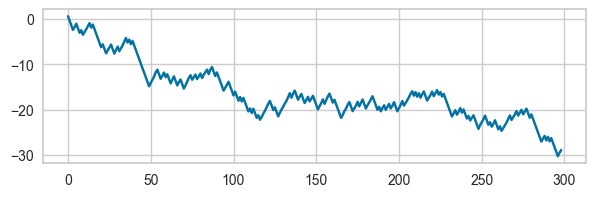

---------------------  TESTE  ---------------------
PL: -0.06 | ROI: -0.02% | Prec.: 0.59
Odd média: 1.69 (0.59 WR)
Média Gain: 0.68 | Média Loss: -1.00
EM: -0.01
305 entradas em 768 jogos (39.71%)


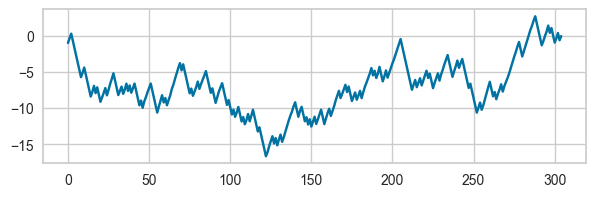

In [61]:
variaveis = features.copy()

ranges_dict = {}

for var in variaveis:
    try:
        new_range = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, return_train=True)
        ranges_dict[var] = new_range
    except:
        pass

# Comparação de modelos

### Escolhendo os modelos

LogisticRegression (i = 0)

PL: -18.00 | ROI: -1.88% | Prec.: 0.59
Odd média: 1.68 (0.59 WR)
Média Gain: 0.67 | Média Loss: -1.00
EM: -0.01
959 entradas em 1690 jogos (56.75%)


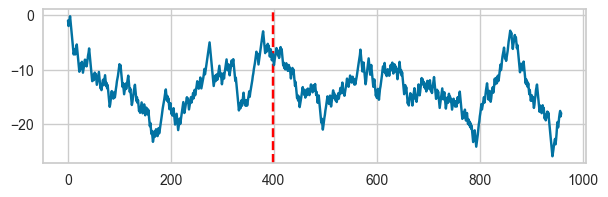

RidgeClassifier (i = 1)

PL: -27.34 | ROI: -2.50% | Prec.: 0.57
Odd média: 1.72 (0.58 WR)
Média Gain: 0.71 | Média Loss: -1.00
EM: -0.03
1092 entradas em 1690 jogos (64.62%)


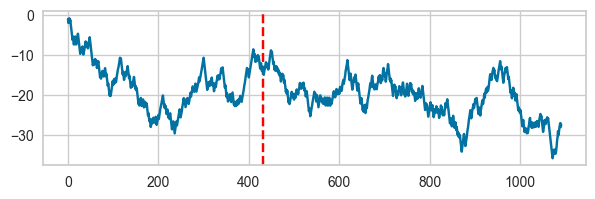

SGDClassifier (i = 2)

PL: -100.89 | ROI: -6.53% | Prec.: 0.52
Odd média: 1.85 (0.54 WR)
Média Gain: 0.81 | Média Loss: -1.00
EM: -0.06
1545 entradas em 1690 jogos (91.42%)


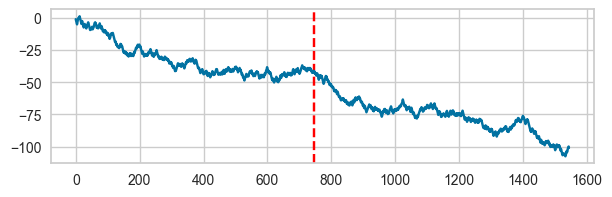

LinearDiscriminantAnalysis (i = 3)

PL: -58.33 | ROI: -8.60% | Prec.: 0.53
Odd média: 1.76 (0.57 WR)
Média Gain: 0.73 | Média Loss: -1.00
EM: -0.09
678 entradas em 1690 jogos (40.12%)


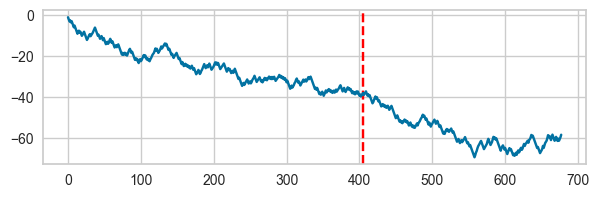

GaussianNB (i = 4)

PL: -76.14 | ROI: -7.73% | Prec.: 0.51
Odd média: 1.85 (0.54 WR)
Média Gain: 0.81 | Média Loss: -1.00
EM: -0.08
985 entradas em 1690 jogos (58.28%)


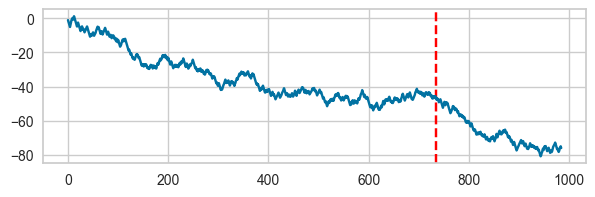

ExtraTreesClassifier (i = 5)

PL: -11.68 | ROI: -1.42% | Prec.: 0.56
Odd média: 1.80 (0.56 WR)
Média Gain: 0.76 | Média Loss: -1.00
EM: -0.01
820 entradas em 1690 jogos (48.52%)


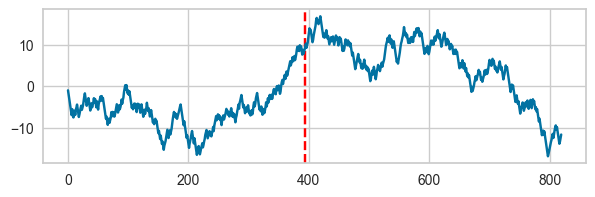

RandomForestClassifier (i = 6)

PL: -25.72 | ROI: -3.00% | Prec.: 0.55
Odd média: 1.81 (0.55 WR)
Média Gain: 0.77 | Média Loss: -1.00
EM: -0.03
857 entradas em 1690 jogos (50.71%)


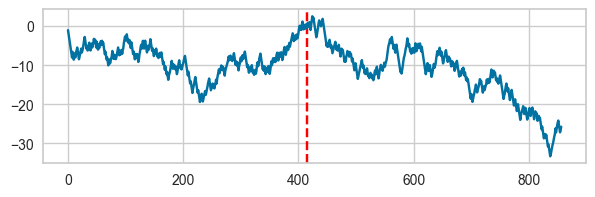

AdaBoostClassifier (i = 7)

PL: -68.40 | ROI: -7.64% | Prec.: 0.53
Odd média: 1.76 (0.57 WR)
Média Gain: 0.73 | Média Loss: -1.00
EM: -0.08
895 entradas em 1690 jogos (52.96%)


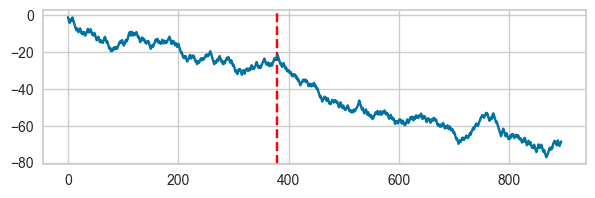

GradientBoostingClassifier (i = 8)

PL: -54.42 | ROI: -6.24% | Prec.: 0.54
Odd média: 1.79 (0.56 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: -0.05
872 entradas em 1690 jogos (51.60%)


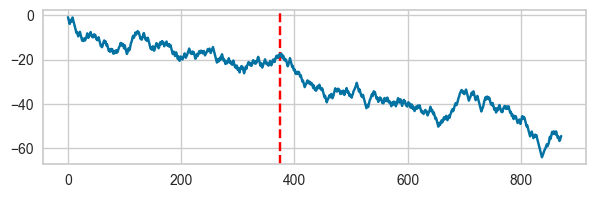

KNeighborsClassifier (i = 9)

PL: -63.39 | ROI: -7.35% | Prec.: 0.53
Odd média: 1.79 (0.56 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: -0.07
863 entradas em 1690 jogos (51.07%)


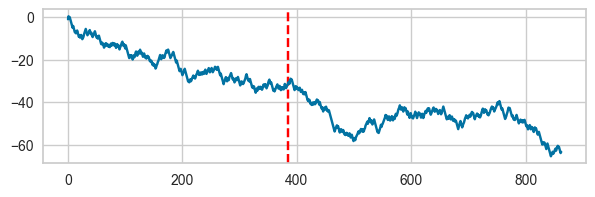

LGBMClassifier (i = 10)

PL: -30.37 | ROI: -3.52% | Prec.: 0.55
Odd média: 1.78 (0.56 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: -0.04
862 entradas em 1690 jogos (51.01%)


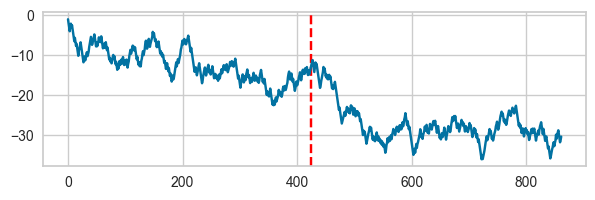

DecisionTreeClassifier (i = 11)

PL: -45.75 | ROI: -5.30% | Prec.: 0.54
Odd média: 1.80 (0.55 WR)
Média Gain: 0.76 | Média Loss: -1.00
EM: -0.05
863 entradas em 1690 jogos (51.07%)


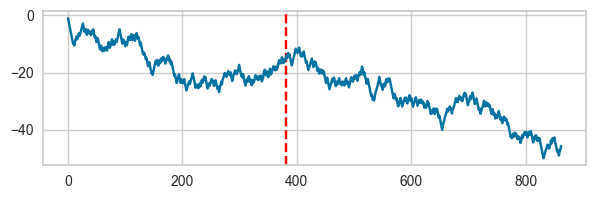

QuadraticDiscriminantAnalysis (i = 12)

O modelo apresentou um erro.

O modelo apresentou um erro.



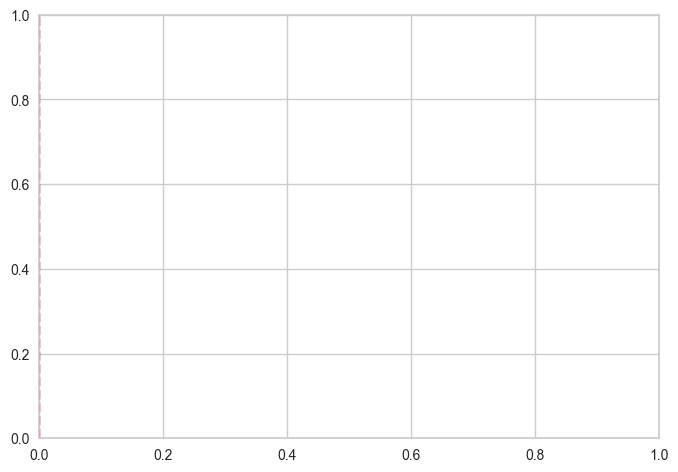

In [52]:
FILTRO = 1
CONJUNTO = 'teste_val'

for i in range(14):
    try:
        if CONJUNTO == 'val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([val1, val2]), filtro = FILTRO)
        elif CONJUNTO == 'teste_val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], real_teste)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val]), filtro = FILTRO)
        elif CONJUNTO == 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

In [ ]:
blended14 = blend_models(estimator_list = [top[1], top[4]], fold = 5, verbose=False)

In [ ]:
model_list = [top[1], top[4], blended14]

### Resultados

In [ ]:
FILTRO = 1

for item in model_list:
    try:
        print(f'{item.__class__.__name__}\n')
        # aux_total = treina_modelo(item, real_teste)
        # aux_total = filtra_resultados(aux_total, filtro = FILTRO)
        # plt.axvline(x=len(aux_total), color='red', linestyle='--')
        # aux = info_modelo(item, pd.concat([real_teste, val]), filtro = FILTRO)
        aux = info_modelo(item, val, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script variáveis

In [13]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA']

colunas = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA']

In [14]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(10, 15)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [15]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('lr', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.extend([ODDS])

    metrics = cria_modelo(fts=feats)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

Rodada 1
**Novo melhor**
Precision: 0.5664
PL: -15.66 | ROI: -3.87% | EM: -0.04 | Prec.: 0.58 | Entradas: 0.53
features = ['CV_Over', 'HA_Line', 'Odds_A', 'Odds_Under', 'HA_Odds_H', 'CV_HA', 'P(O)', 'HA_Odds_A', 'P(A)', 'CV_ML', 'Odds_Over', 'Odds_H']


Rodada 2
**Novo melhor**
Precision: 0.5544
PL: -12.28 | ROI: -3.03% | EM: -0.03 | Prec.: 0.59 | Entradas: 0.53
features = ['CV_Over', 'HA_Odds_H', 'P_Diff', 'Odds_Over', 'P(H)', 'CV_HA', 'Odds_Under', 'Over_Line', 'P(O)', 'CV_ML', 'HA_Odds_A', 'HA_Line', 'P(A)', 'P(U)', 'Odds_A', 'Odds_H']


Rodada 3
**Novo melhor**
Precision: 0.5555
PL: -10.48 | ROI: -2.59% | EM: -0.03 | Prec.: 0.59 | Entradas: 0.53
features = ['Odds_Over', 'P(O)', 'P(H)', 'HA_Odds_H', 'CV_HA', 'Over_Line', 'HA_Line', 'P_Diff', 'CV_ML', 'Odds_A', 'P(A)', 'Odds_Under', 'Odds_H']


Rodada 4

Rodada 5

Rodada 6

Rodada 7

Rodada 8
**Novo melhor**
Precision: 0.5607
PL: -9.71 | ROI: -2.39% | EM: -0.03 | Prec.: 0.59 | Entradas: 0.53
features = ['P(H)', 'P_Diff', 'Odds_A', 'O

# Segundo filtro

In [19]:
fits = ['Over_Line', 'P(A)', 'CV_Over', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_Odds_A', 'Odds_Over', 'CV_HA', 'Odds_H']


In [20]:
metrics = cria_modelo(fits)
prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

---------------------- BASE ----------------------
Precision: 0.5574
PL: -7.18 | ROI: -1.80% | EM: -0.01 | Prec.: 0.60 | Entradas: 0.52
fits = ['Over_Line', 'P(A)', 'CV_Over', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_Odds_A', 'Odds_Over', 'CV_HA', 'Odds_H']

--------------------------------------------------
Removido: Over_Line
Precision: 0.5591
PL: -8.86 | ROI: -2.08% | EM: -0.02 | Prec.: 0.59 | Entradas: 0.55
fits = ['P(A)', 'CV_Over', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_Odds_A', 'Odds_Over', 'CV_HA', 'Odds_H']


Removido: P(A)
Precision: 0.5622
PL: -8.18 | ROI: -2.03% | EM: -0.03 | Prec.: 0.59 | Entradas: 0.52
fits = ['Over_Line', 'CV_Over', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_Odds_A', 'Odds_Over', 'CV_HA', 'Odds_H']


Removido: CV_Over
Precision: 0.5484
PL: -9.10 | ROI: -2.25% | EM: -0.03 | Prec.: 0.59 | Entradas: 0.53
fits = ['Over_Line', 'P(A)', 'P(H)', 'P_Diff', 'CV_ML', 'HA_Odds_H', 'Odds_A', 'P(U)', 'HA_O

# Cross validation

In [ ]:
results_wr = []
results_pl = []
results_roi = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('lr', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 2)
        previsoes = calcula_profit(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
        
        results_wr.append(wr)
        results_pl.append(plb)
        results_roi.append(roi)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        exibe_grafico(previsoes)
        print()

print(f'WR  Média: {np.mean(results_wr):.2f} | DP: {np.std(results_wr):.2f}\n')
print(f'PROFIT  Média: {np.mean(results_pl):.2f} | DP: {np.std(results_pl):.2f}\n')
print(f'ROI  Média: {np.mean(results_roi):.2f} | DP: {np.std(results_roi):.2f}\n')

In [ ]:
8027
6383
7107

# Entradas Aleatórias

In [ ]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = - (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = 0.97
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

In [ ]:
new_random_model(val, 10)